In [1]:
import numpy as np
from scipy import signal
from scipy.fft import fft, fftfreq, irfft, dct, idct
import cv2
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

import sig_analize as san
import generate_areas as ga
%load_ext autoreload
%autoreload 2

In [2]:
dir_path = './drop-211025-2'
img_path_list = [dir_path + '/'+ f for f in os.listdir(dir_path) if f.endswith('.jpg')]
img_path_list.sort()
img_path_list

['./drop-211025-2/drop-010.jpg',
 './drop-211025-2/drop-020.jpg',
 './drop-211025-2/drop-030.jpg',
 './drop-211025-2/drop-040.jpg',
 './drop-211025-2/drop-050.jpg',
 './drop-211025-2/drop-060.jpg',
 './drop-211025-2/drop-070.jpg',
 './drop-211025-2/drop-080.jpg',
 './drop-211025-2/drop-090.jpg',
 './drop-211025-2/drop-100.jpg',
 './drop-211025-2/drop-110.jpg',
 './drop-211025-2/drop-120.jpg',
 './drop-211025-2/drop-130.jpg',
 './drop-211025-2/drop-140.jpg',
 './drop-211025-2/drop-150.jpg',
 './drop-211025-2/drop-160.jpg',
 './drop-211025-2/drop-170.jpg',
 './drop-211025-2/drop-180.jpg',
 './drop-211025-2/drop-190.jpg',
 './drop-211025-2/drop-200.jpg']

In [3]:
json_path = 'sequence.txt'

ga.choose_multy(img_path_list, json_path, mode='common')

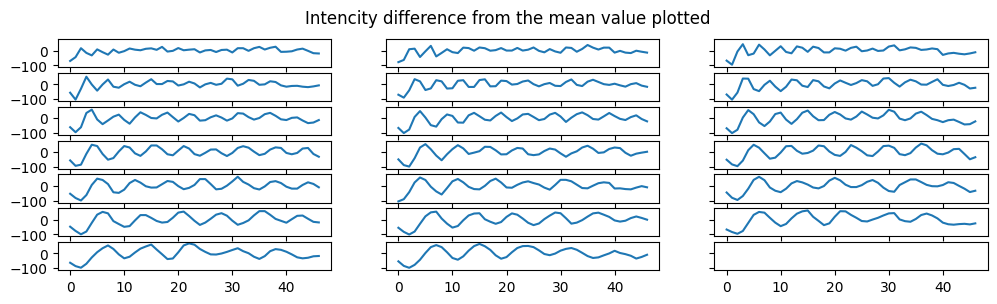

In [5]:
# upload ntencity distributions from json file and
# look at the integral intencity distribution plotted

with open(json_path,'r') as f:
    imgs = json.load(f)[:-1]

img_count = len(imgs)
row_count = (img_count+2)//3

fig, ax = plt.subplots(row_count, 3, figsize=(12, row_count//2), sharex=True, sharey=True)

for i in range(img_count):
    ax[i//3][i%3].plot(imgs[i])
plt.suptitle("Intencity difference from the mean value plotted")
plt.show()

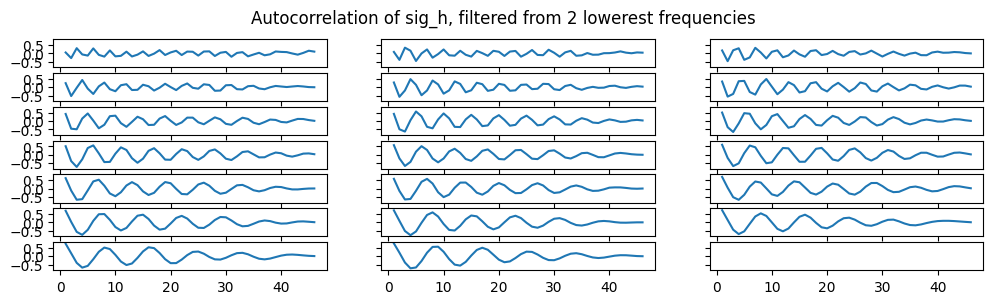

In [6]:
# to make peaks more prominent it is nesessary to
# remove low frequencies from the signals
# we will use san.my_butter_high to create high pass filter
sig_len = len(imgs[0])  # for mode='commom' length is the same for all signals

fs=1
nl = 2
f_min = nl/sig_len
border = 4

bh, ah = signal.butter(border, f_min, btype = 'highpass', fs=fs)
sig_h = [signal.filtfilt(bh, ah, img, method='gust') for img in imgs]

cor_res =  [san.auto_corr(sig, sig_len, dt=1) for sig in sig_h]

fig, ax = plt.subplots(row_count, 3, figsize=(12, row_count//2), sharex=True, sharey=True)
for i in range(img_count):
    ax[i//3][i%3].plot(*cor_res[i])
plt.suptitle(f"Autocorrelation of sig_h, filtered from {nl} lowerest frequencies")
plt.show()

In [7]:
# counting peaks in original signal

peak_count = [san.peak_counter(cor[1])[0] for cor in cor_res]
print(peak_count)

[14, 13, 12, 11, 11, 10, 9, 9, 8, 8, 7, 7, 6, 6, 6, 6, 5, 5, 5, 5]


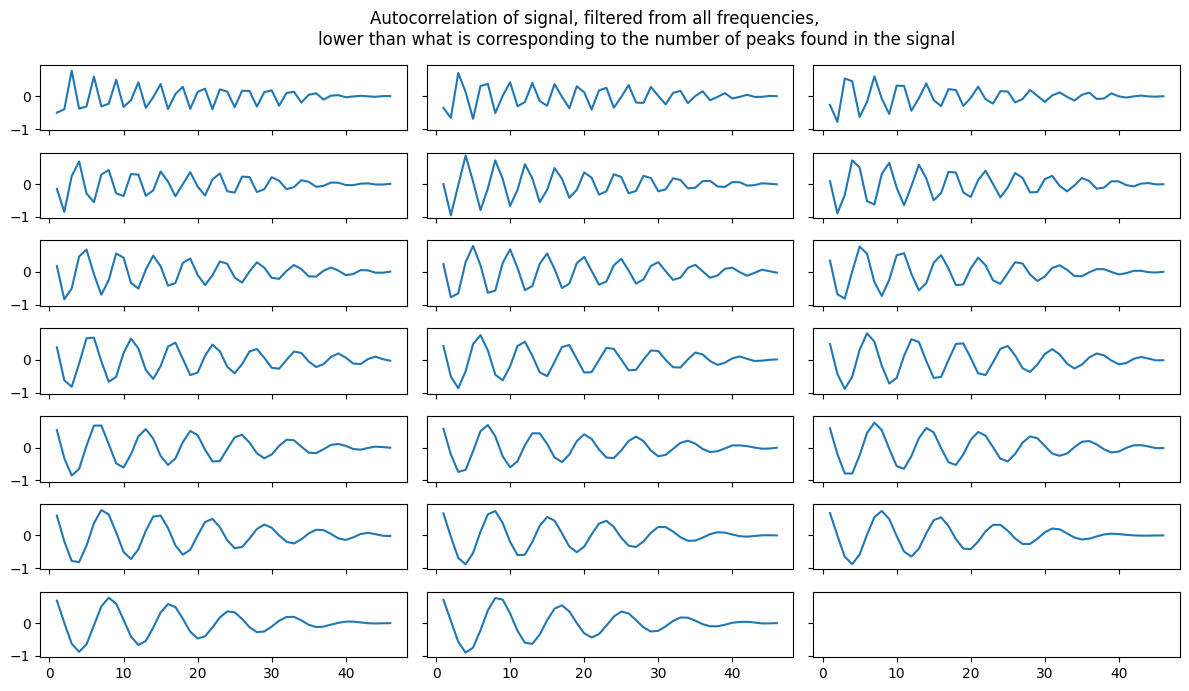

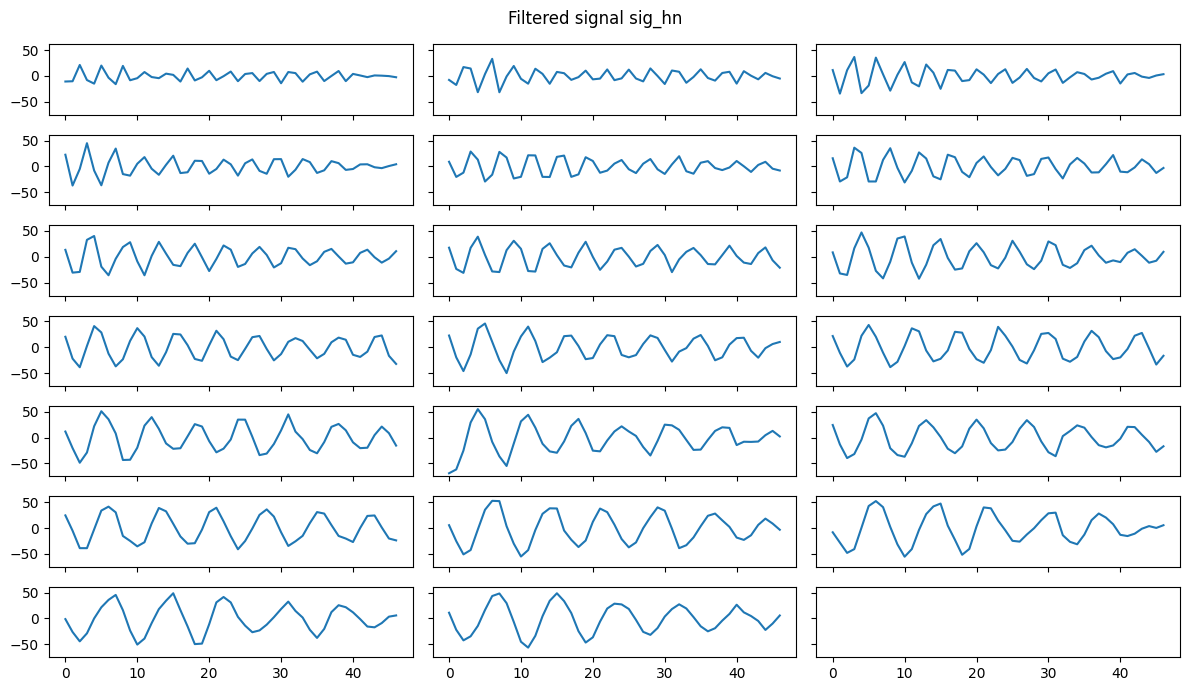

In [8]:
# to make peaks more prominent it is nesessary to
# remove low frequencies from the signals
# we will use san.my_butter_high to create high pass filter
# !!! here we use nl = number of peaks in autocorrelation function

fs = 1
border = 4

sig_hn = []

for i in range(img_count):
    nl = peak_count[i]-1
    f_min = nl/sig_len


    bh, ah = signal.butter(border, f_min, btype = 'highpass', fs=fs)
    sig_hn.append(signal.filtfilt(bh, ah, sig_h[i], method='gust'))


fig, ax = plt.subplots(row_count, 3, figsize=(12, row_count), sharex=True, sharey=True)
for i in range(img_count):
    ax[i//3][i%3].plot(*san.auto_corr(sig_hn[i], sig_len, dt=1/fs))
plt.suptitle("Autocorrelation of signal, filtered from all frequencies,\n\
                lower than what is corresponding to the number of peaks found in the signal")
plt.tight_layout()
plt.show()

sig_x = np.arange(sig_len)

fig, ax = plt.subplots(row_count, 3, figsize=(12, row_count), sharex=True, sharey=True)
for i in range(img_count):
    ax[i//3][i%3].plot(sig_x, sig_hn[i])
plt.suptitle("Filtered signal sig_hn")
plt.tight_layout()
plt.show()

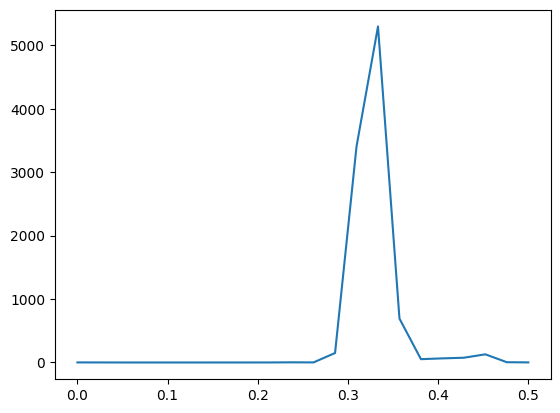

In [61]:
fxx, Pxx_den = signal.welch(np.real(sig_hn[2]), fs = 1, nperseg=int(sig_len))
plt.plot(fxx, Pxx_den)

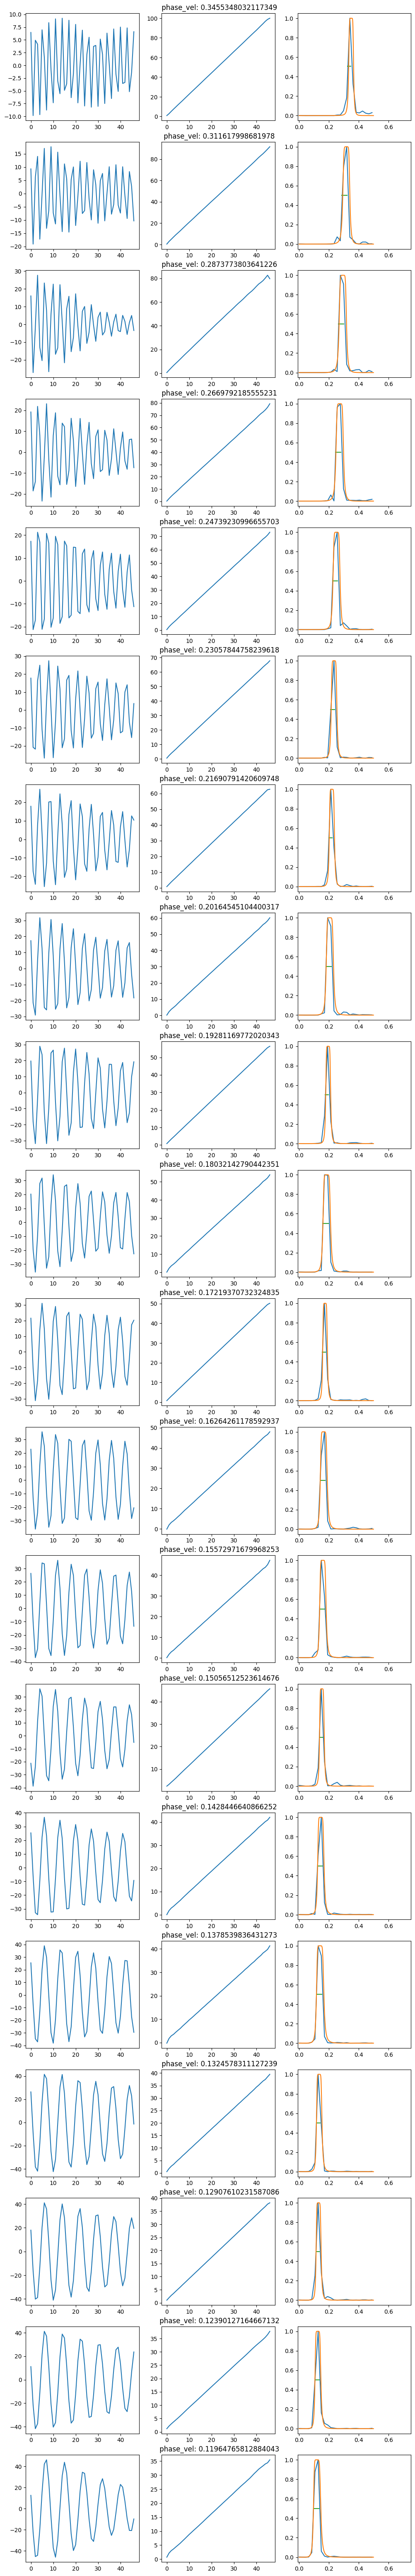

In [9]:
ph_vel_hn = san.plot_flt_res(sig_hn, fs=1, rel_h=0.5, nperseg_c=1)

0.009621875667595195


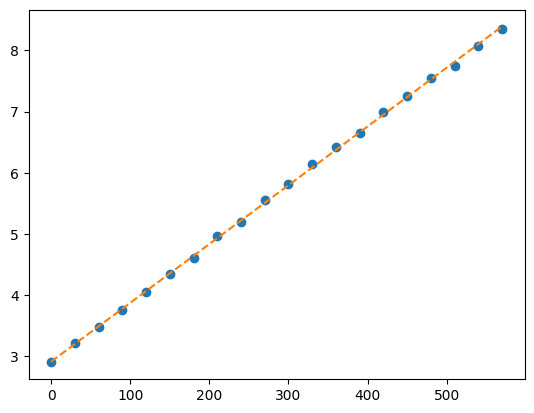

In [10]:
time = np.arange(img_count)*3*10

with open('start2.txt','w') as f:
    for t, val in zip(time, 1/np.array(ph_vel_hn)):
        f.write(f"{t} {val:.3f}\n")

slope, intercept = np.polyfit(time, 1/np.array(ph_vel_hn), 1)
phase_vel_line = time*slope + intercept

plt.figure()
plt.plot(time, 1/np.array(ph_vel_hn), 'o')
plt.plot(time, phase_vel_line, '--')
print(slope)

Мы получили графики зависимости обратной скорости изменения фазы вдоль направления 
растекания капли от времени (момента, когда кадр был запечетлен), они описываются прямыми.
$$\frac{1}{\frac{d\phi}{dx}} = t*A + В$$, А - коэффициент пропорциональности
Трение вычисляется по формуле
$$\tau = \frac{dx}{dh}\mu\frac{1}{t}$$
$$\frac{1}{\frac{dh}{dx}} = \frac{\tau}{\mu}t$$
Зависимость фазы от высоты пленки:
$$h=\frac{\lambda}{4\pi}\phi\frac{1}{n_{oil}^2-n_{air}^2\sin{\psi}}$$

Где $\psi$ - угол падения луча (у нас - угол наклона камеры); $\psi = 5град = 0.087 рад$  
$n_{oil} = 1.4, n_{air} = 1$  
$\lambda = 443 nm = 443*10^{-9} m$  
$\nu = 1000 sSt = 10^{-3} m^2/s$ - кинематическая вязкость  
$\mu = \nu \rho = 0.97 кг/(м*с)- динамическая вязкость;    \rho = 971  kg/m^3$  при 20 градусах цельсия
$$\frac{1}{\frac{d\phi}{dx}} = t\tau A$$
где $A = \frac{\lambda}{4\pi\mu (n_{oil}^2-n_{air}^2\sin{\psi})} \approx 18.55 * 10^{-9}$
Значение наклона прямой, полученное интерполяцией неоюходимо разделить на 18.55 * 10^{-9},
чтобы получить $\tau$

X  до этого момента выражалась в пикселях, 
разрешение камеры примерно 27800 пиксель/м.
То есть реальные коэффициент наклона прямой можно получить, если коэффициент, полученный из интерполяции, умножить
на 27800.

In [11]:
file_list = ['start2.txt','start3.txt','start4.txt','start5.txt']

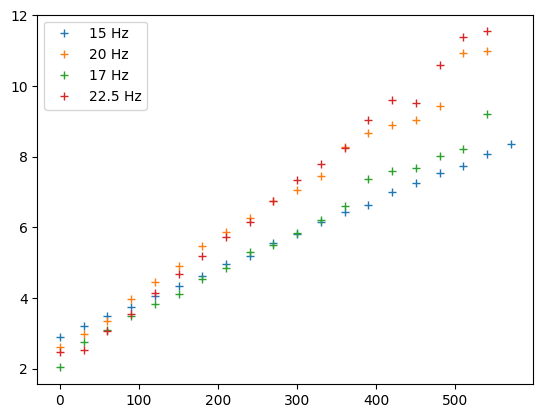

[np.float64(18.52513455375057), np.float64(29.453125175922747), np.float64(23.564526770655306), np.float64(33.82614217484413)]


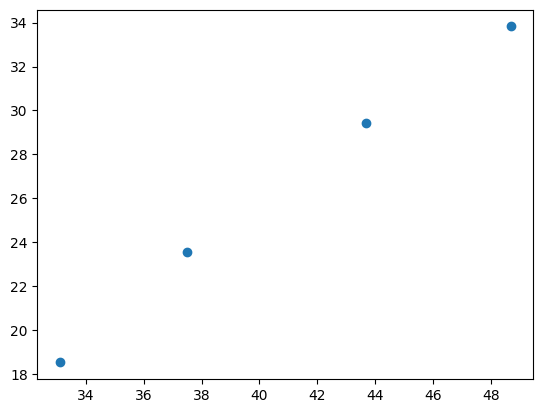

In [15]:
fric = []

plt.figure()

for file in file_list:
    time_f = []
    phase_vel_rev = []
    with open(file, 'r') as f:
        for line in f:
            t, ph = line.strip().split(' ')
            time_f.append(int(t))
            phase_vel_rev.append(float(ph))

    slope, intercept = np.polyfit(time_f, phase_vel_rev, 1)
    fric.append(slope/18.55*10**5/2.8)
    phase_vel_line = np.array(time_f)*slope + intercept
    
    plt.plot(time_f, phase_vel_rev, '+')
    #plt.plot(time_f, phase_vel_line, '--')

plt.legend(labels=['15 Hz','20 Hz','17 Hz','22.5 Hz'])
plt.show()

print(fric)

frq = [33.1, 43.7, 37.5, 48.7]
plt.figure()
plt.plot(frq, fric, 'o')
plt.show()

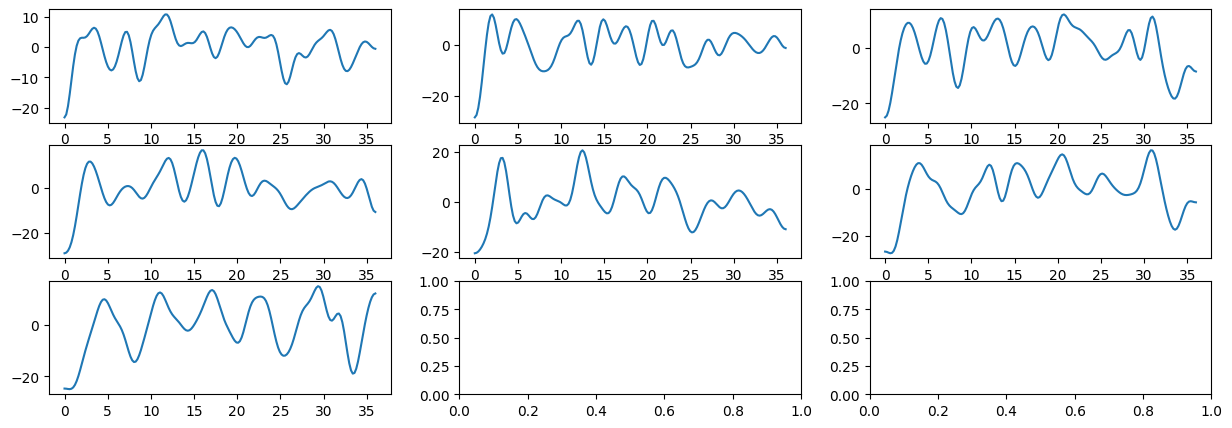

In [91]:
# approximate the graphssig_hn  with sums of cosinusoids using dct
# and plot the smoother versions 

N = sig_len*5
fs = N/sig_len

coeffs = [dct(sig) for sig in imgs]
sig_sm = [san.fourie_restore(coeff, sig_len, fs, N, mode='cos') for coeff in coeffs]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*sig_sm[i])

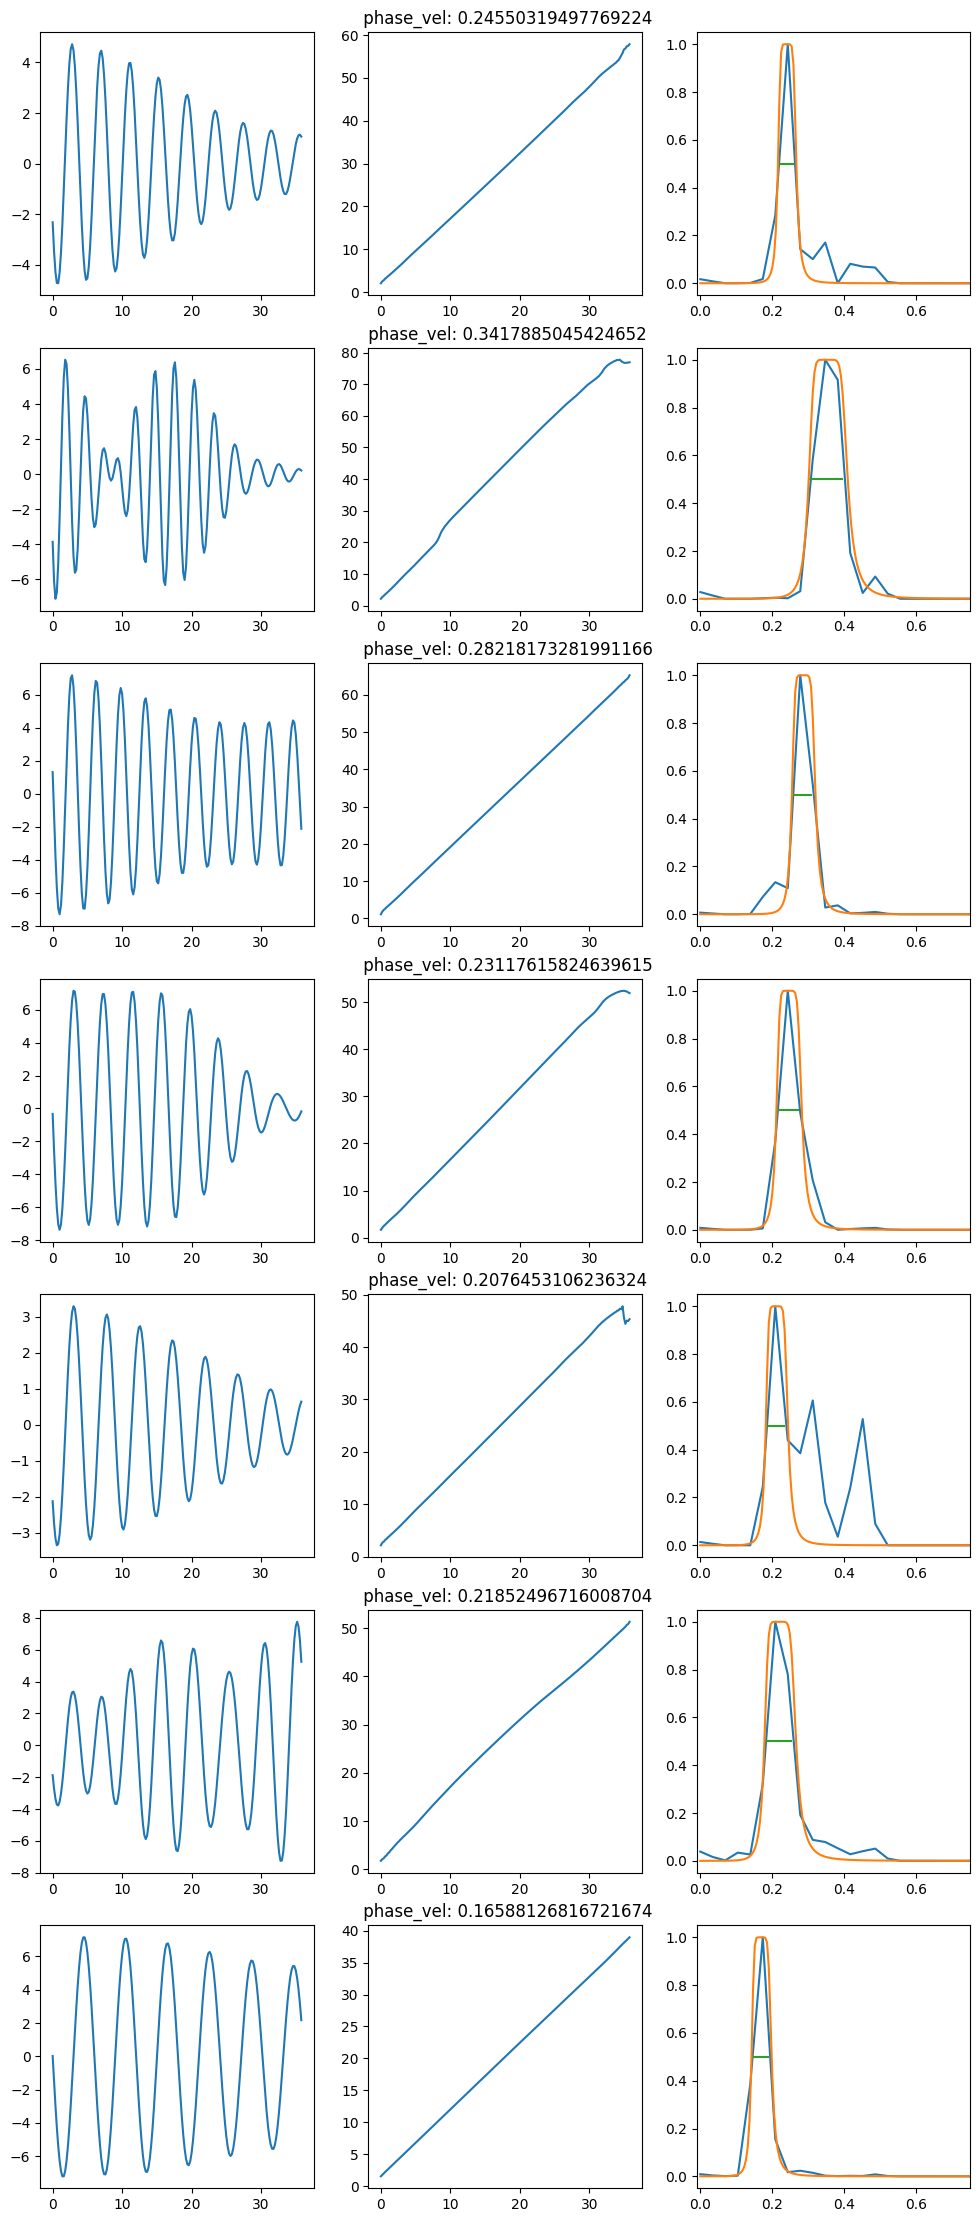

In [92]:
# filtering smoothed signals with san.my_butter and plot filtered signal
# applying signal.hilbert to the filtered signal and plot instant phase
# plot spectral density destribution and filter responce to monitor

fs = N/sig_len
sig_y = [s[1] for s in sig_hn_sm] 

ph_v = san.plot_flt_res(sig_y, fs=fs, rel_h=0.5, nperseg_c=0.8)

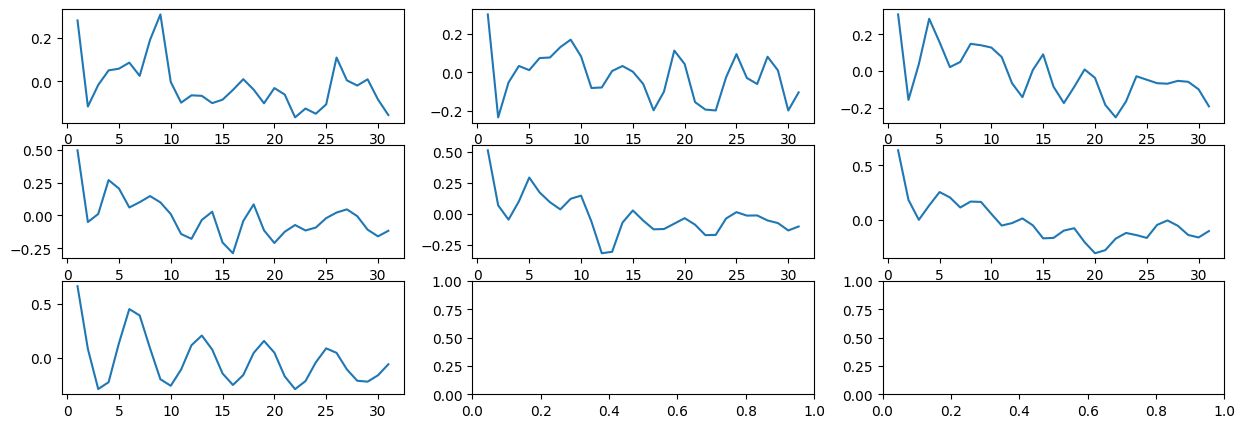

In [14]:
# Let's look at autocorrelation functions of original signals
sig_y = [s[1] for s in sig_sm]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*san.auto_corr(imgs[i], sig_len, dt=1))

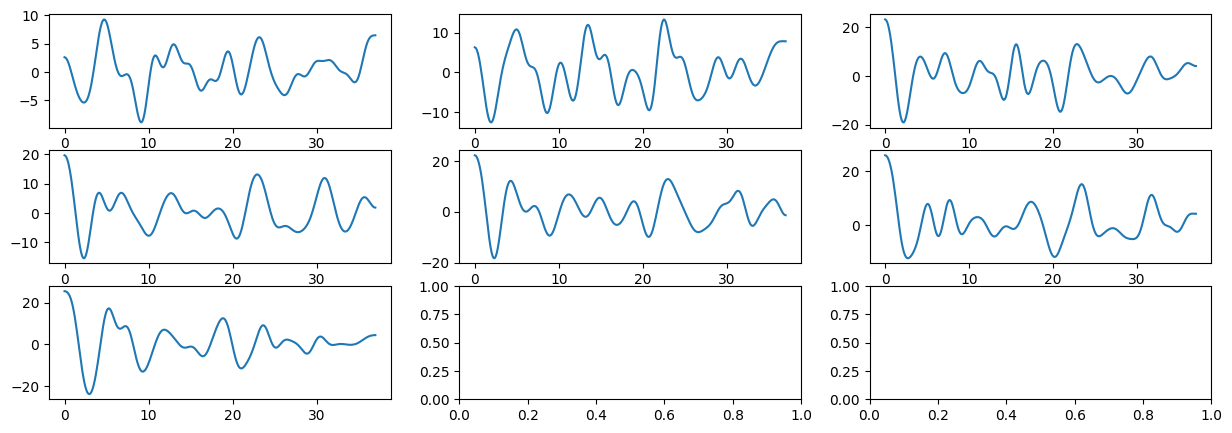

In [10]:
N = 300
fs = N/sig_len

coeffs = [dct(sig) for sig in sig_h]
sig_h_sm = [san.fourie_restore(coeff, sig_len, fs, N, mode='cos') for coeff in coeffs]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*sig_h_sm[i])

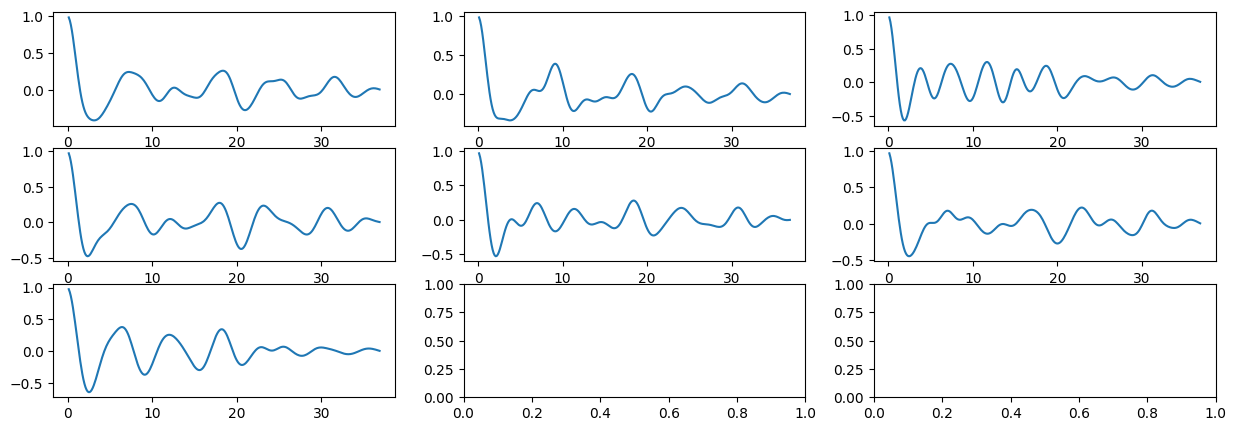

In [11]:
sig_h_sm_y = [s[1] for s in sig_h_sm]

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

cor_res =  [san.auto_corr(sig_h_sm_y[i], N, dt=1/fs) for i in range(img_count)]

for i in range(img_count):
    ax[i//3][i%3].plot(*cor_res[i])

In [12]:
peak_counts = [san.peak_counter(cor[1])[0] for cor in cor_res]
print(peak_counts)

[6, 8, 9, 6, 8, 9, 7]


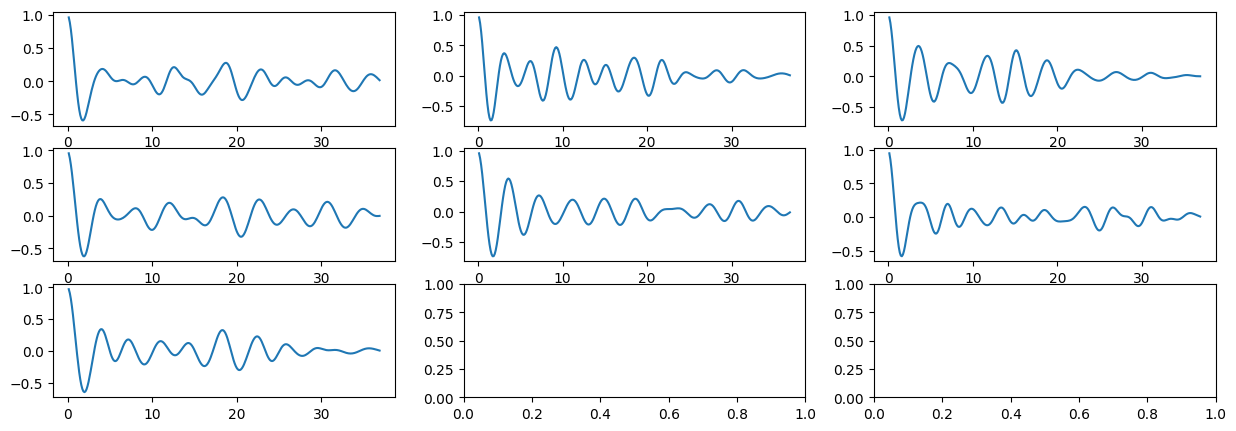

In [13]:
# to make peaks more prominent it is nesessary to
# remove low frequencies from the signals
# we will use san.my_butter_high to create high pass filter
# !!! here we use nl = number of peaks in autocorrelation function
N = 300
fs = N/sig_len
border = 4

sig_h = []

for i in range(img_count):
    nl = peak_counts[i]
    f_min = nl/sig_len


    bh, ah = signal.butter(border, f_min, btype = 'highpass', fs=fs)
    sig_h.append(signal.filtfilt(bh, ah, sig_h_sm_y[i], method='gust'))

fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(*san.auto_corr(sig_h[i], N, dt=1/fs))

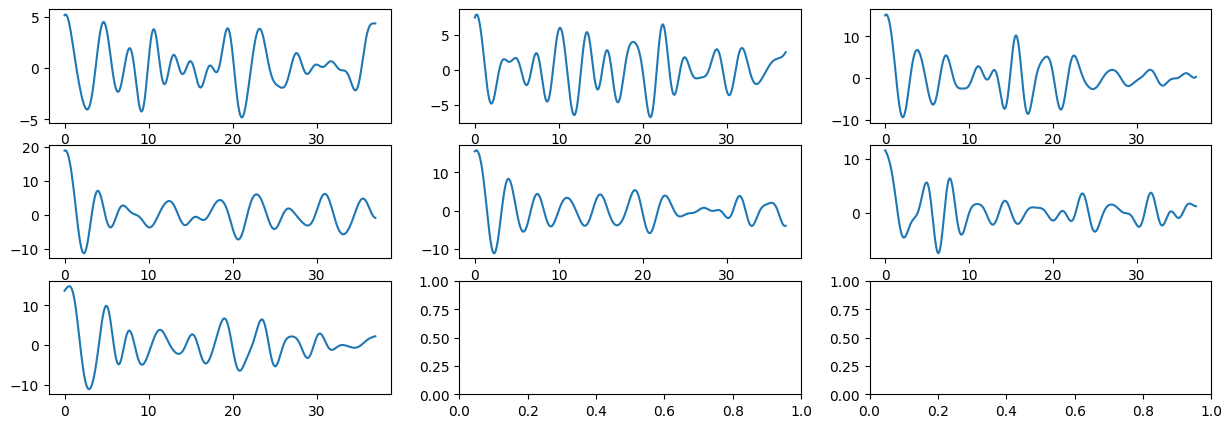

In [14]:
fig, ax = plt.subplots(row_count, 3, figsize=(5*row_count, 5))

for i in range(img_count):
    ax[i//3][i%3].plot(sig_h_sm[0][0], sig_h[i])



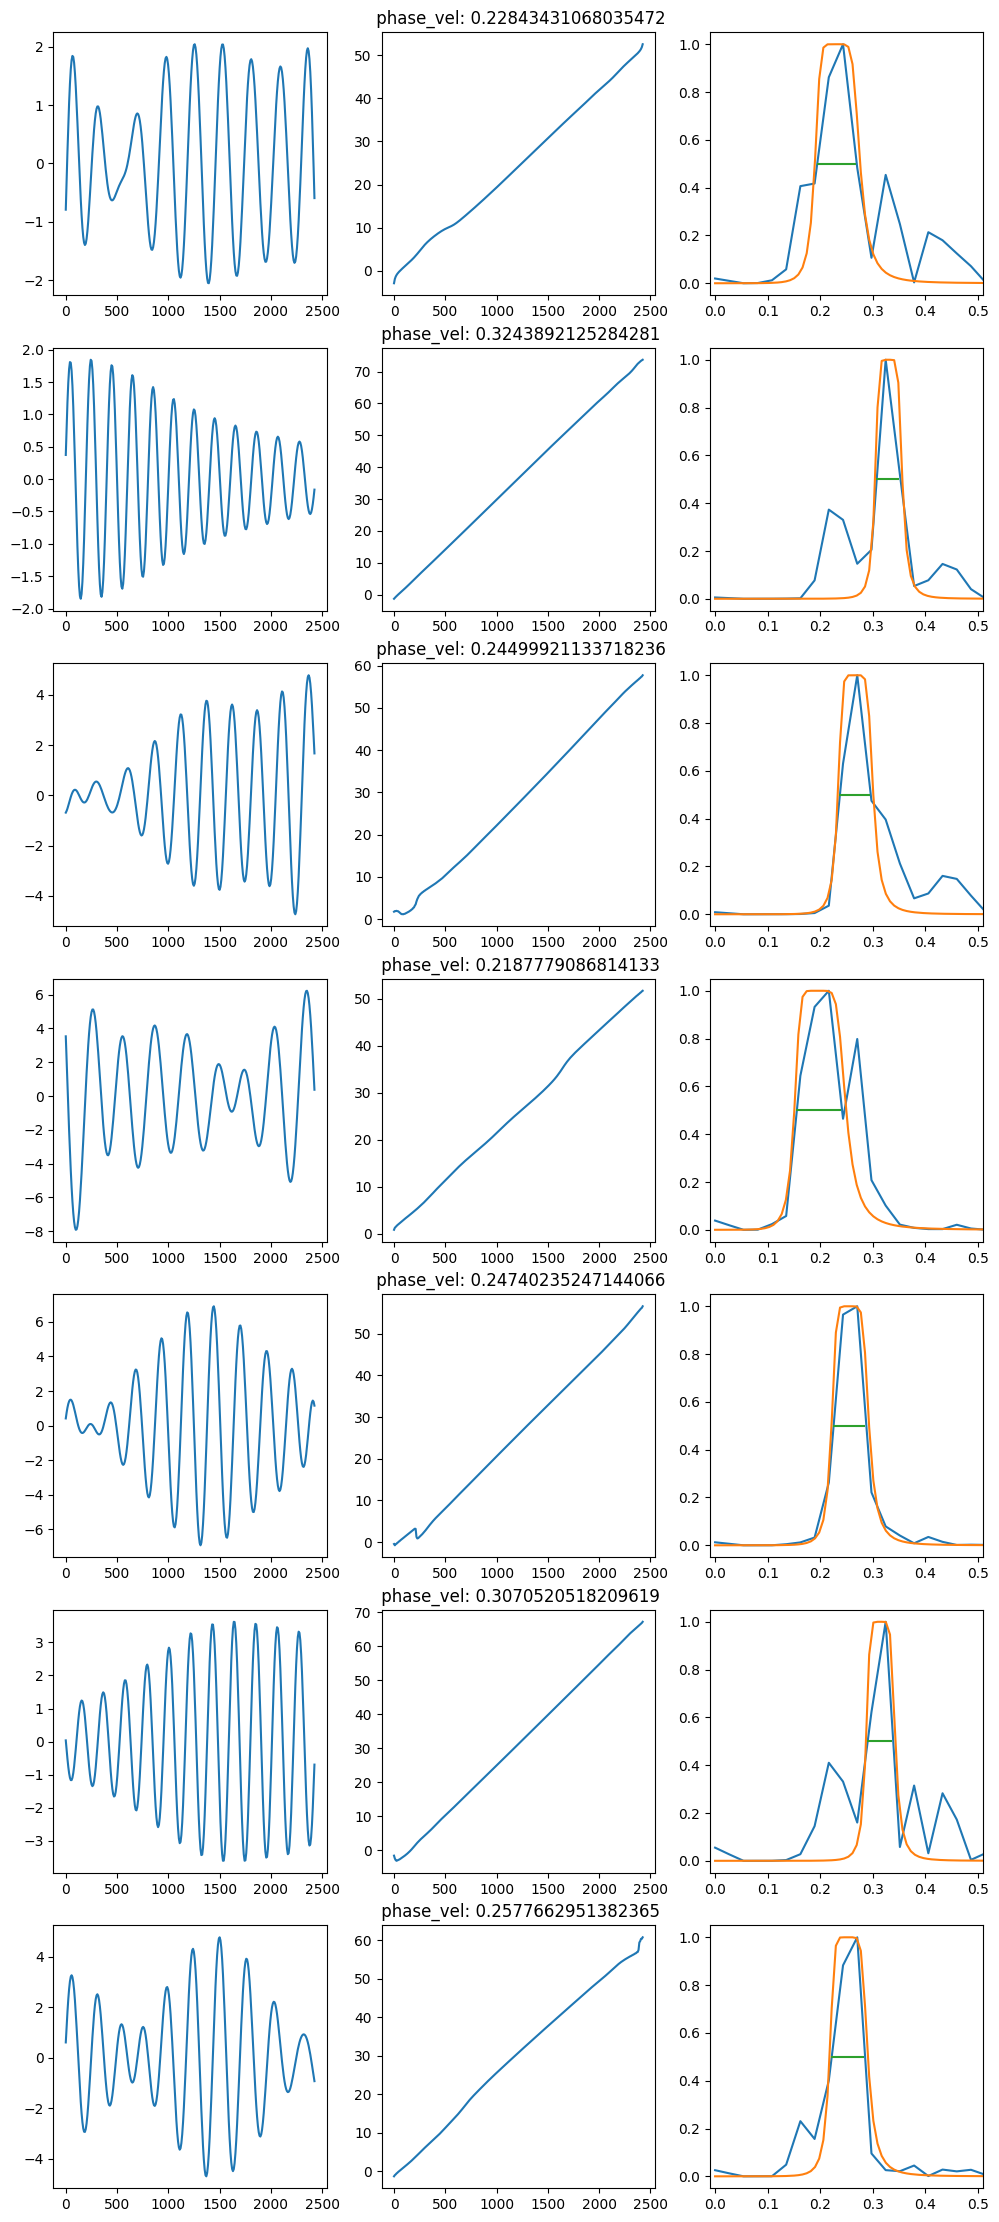

In [15]:
N = 300
fs = N/sig_len
phase_vel = plot_flt_res(sig_h, fs=fs, rel_h=0.5, nperseg_c=1)

In [85]:
print(slope)

-0.0004967711580463839
